# Test Encodec receptive field

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from tqdm import tqdm

In [2]:
from shared import *
from my_encodec import getEncodec

c:\Users\iGlop\anaconda3\envs\env_neural_avh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [3]:
encodec = getEncodec()

c:\Users\iGlop\anaconda3\envs\env_neural_avh\Lib\site-packages\torch\nn\utils\weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [4]:
T = 30
wave = torch.randn((1, 1, T * ENCODEC_SR), device=DEVICE)
codes, scale = encodec.encode(wave)
print(scale)
print(codes.shape)
print(T * ENCODEC_FPS)
del wave
del codes

None
torch.Size([1, 4, 1500])
1500


100%|██████████| 6/6 [02:33<00:00, 25.58s/it]


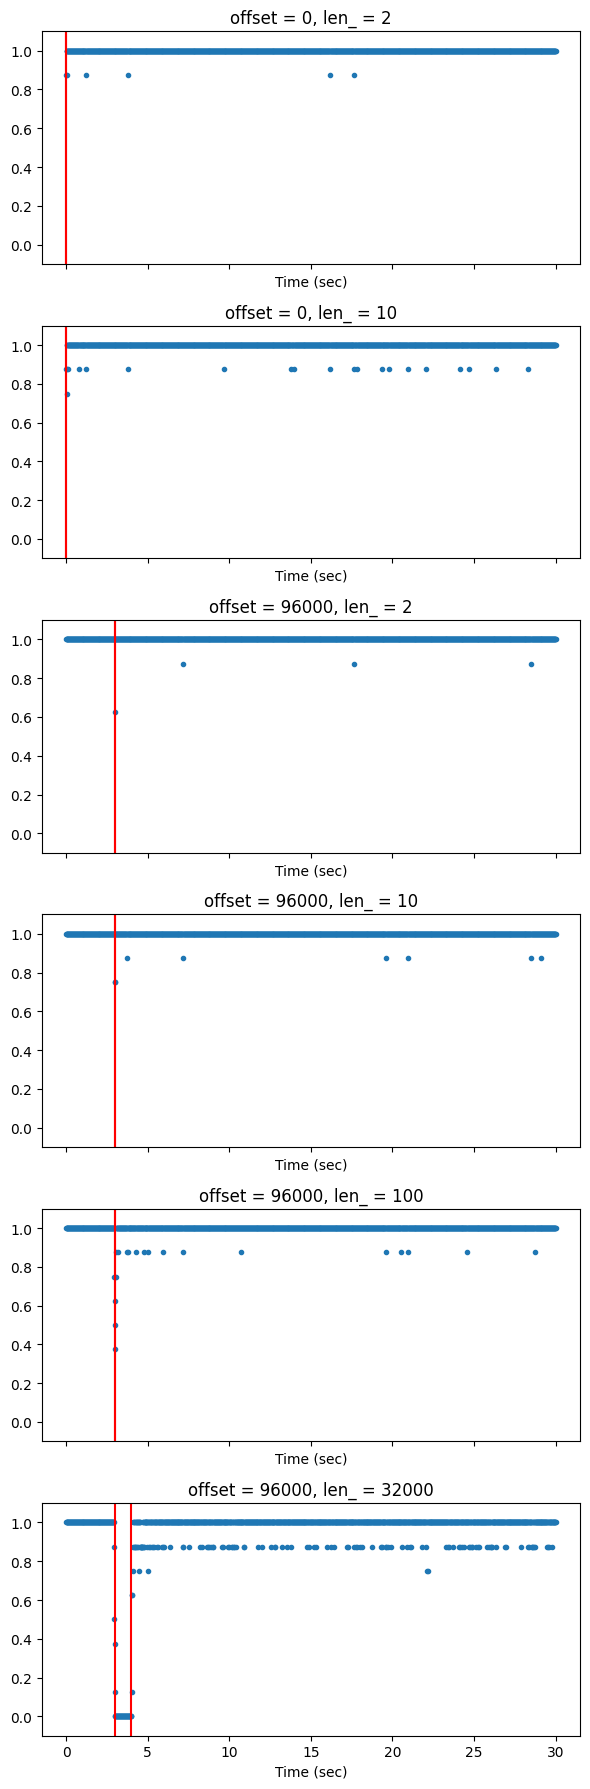

In [6]:
def f():
    BATCH_SIZE = 8
    TESTS = [
        (0, 2), 
        (0, 10), 
        (ENCODEC_SR * 3, 2), 
        (ENCODEC_SR * 3, 10),
        (ENCODEC_SR * 3, 100),
        (ENCODEC_SR * 3, ENCODEC_SR),
    ]
    wave = torch.randn((BATCH_SIZE, 1, T * ENCODEC_SR), device=DEVICE)
    codes, scales = encodec.encode(wave)
    assert scales is None

    def g(offset: int, len_: int) -> np.ndarray:
        perturbed = wave.clone()
        perturbed[:, :, offset:offset+len_] = perturbed[:, :, offset:offset+len_].flip(dims=(2, ))
        codes_p, scales = encodec.encode(perturbed)
        assert scales is None
        return (codes_p == codes).all(dim=1).to(torch.float).mean(dim=0).cpu().numpy()    
    
    fig, axes = plt.subplots(len(TESTS), 1, figsize=(6, 3 * len(TESTS)), sharex=True)
    for test, ax in zip(tqdm(TESTS), axes):
        ax: Axes
        offset, len_ = test
        delta = g(offset, len_)
        ax.plot(np.linspace(0, T, delta.shape[0]), delta, '.')
        ax.axvline((offset) / ENCODEC_SR, color='r')
        ax.axvline((offset + len_) / ENCODEC_SR, color='r')
        ax.set_ylim(-.1, 1.1)
        ax.set_title(f'{offset = }, {len_ = }')
        ax.set_xlabel('Time (sec)')
    fig.tight_layout()
    plt.show()

with torch.no_grad():
    f()

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:04<00:00,  2.41s/it]


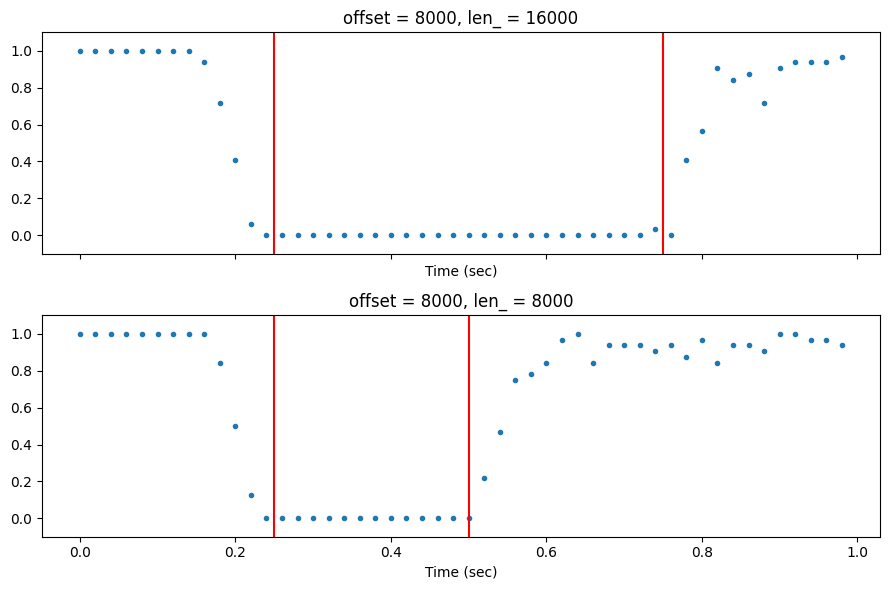

In [10]:
def f():
    T = 1
    BATCH_SIZE = 32
    TESTS = [
        (ENCODEC_SR // 4, ENCODEC_SR // 2),
        (ENCODEC_SR // 4, ENCODEC_SR // 4),
    ]
    wave = torch.randn((BATCH_SIZE, 1, T * ENCODEC_SR), device=DEVICE)
    codes, scales = encodec.encode(wave)
    assert scales is None

    def g(offset: int, len_: int) -> np.ndarray:
        perturbed = wave.clone()
        perturbed[:, :, offset:offset+len_] = perturbed[:, :, offset:offset+len_].flip(dims=(2, ))
        codes_p, scales = encodec.encode(perturbed)
        assert scales is None
        return (codes_p == codes).all(dim=1).to(torch.float).mean(dim=0).cpu().numpy()    
    
    fig, axes = plt.subplots(len(TESTS), 1, figsize=(9, 3 * len(TESTS)), sharex=True)
    for test, ax in zip(tqdm(TESTS), axes):
        ax: Axes
        offset, len_ = test
        delta = g(offset, len_)
        ax.plot(np.linspace(0, T, delta.shape[0] + 1)[:-1], delta, '.')
        ax.axvline((offset) / ENCODEC_SR, color='r')
        ax.axvline((offset + len_) / ENCODEC_SR, color='r')
        ax.set_ylim(-.1, 1.1)
        ax.set_title(f'{offset = }, {len_ = }')
        ax.set_xlabel('Time (sec)')
    fig.tight_layout()
    plt.show()

with torch.no_grad():
    f()